In [1]:
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import text_to_word_sequence

import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

In [2]:
# Displaying all columns
pd.set_option('display.max_columns', None)

#Display all data in columns
pd.set_option("display.max_colwidth", None)

np.set_printoptions(threshold=None, edgeitems=None, linewidth=None, suppress=None)
pd.set_option("display.max_rows", None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

In [8]:
train_df = pd.read_csv('train.csv')

In [9]:
train_df.shape

(120000, 3)

In [10]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."


In [11]:
# Adding new column for preprocessed text
train_df['Description_preprocessed'] = train_df['Description']

In [3]:
#Dependencies
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Checking for duplicates
train_df.duplicated().sum()

np.int64(0)

In [15]:
# Checking for null values
train_df.isnull().sum()

,0
Class Index,0
Title,0
Description,0
Description_preprocessed,0


In [16]:
# Checking of data is imbalanced
train_df['Class Index'].value_counts()

,count
Class Index,
3,30000
4,30000
2,30000
1,30000


In [4]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [4]:
!pip install contractions
!pip install wordcloud
!pip install autocorrect
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Preprocessing 'Description overview' column

import re
import string
import spacy
import contractions
from nltk.corpus import stopwords
import nltk

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define stopwords list
stop_words = set(stopwords.words('english'))

# Combined preprocessing function
def preprocess(text):
    if not isinstance(text, str):
        return ""

    # Lowercase and tokenization
    doc = nlp(text.lower())

    # Expand contractions
    expanded = " ".join([contractions.fix(token.text) for token in doc])

    # Remove HTML tags
    expanded = re.sub(r'<.*?>', '', expanded)

    # Remove URLs
    expanded = re.sub(r'https?://\S+|www\.\S+', '', expanded)

    # Remove '@'s and '#'s
    expanded = re.sub(r"(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)", " ", expanded)

    # Remove punctuation
    expanded = expanded.translate(str.maketrans('', '', string.punctuation))

    # Tokenize again after cleanup
    doc = nlp(expanded)

    # Remove stopwords
    tokens = [token for token in doc if token.text not in stop_words and not token.is_space]

    # Lemmatization
    lemmatized = [token.lemma_ for token in tokens]

    return " ".join(lemmatized)

train_df['Description_preprocessed'] = train_df['Description'].apply(preprocess)

In [21]:
train_df[['Description', 'Description_preprocessed']].head()

,Description,Description_preprocessed
0,"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",reuters short seller wall street dwindlingband ultra cynic see green
1,"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market
2,Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum
3,"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday
4,"AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election


In [22]:
# Adding new column for title column
train_df['Title_processed'] = train_df['Title']

In [23]:
# Combined function for preprocessing Title
def preprocess_title(text):
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Expand contractions using tokenization
    text = " ".join([contractions.fix(token.text) for token in nlp(text)])

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove '@'s and '#'s
    text = re.sub(r"(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)", " ", text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize again after cleaning
    doc = nlp(text)

    # Remove stopwords and lemmatize
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]

    return " ".join(tokens)

train_df['Title_processed'] = train_df['Title_processed'].apply(preprocess_title)

In [25]:
train_df[['Title', 'Title_processed']].head()

,Title,Title_processed
0,Wall St. Bears Claw Back Into the Black (Reuters),wall st bear claw back black reuter
1,Carlyle Looks Toward Commercial Aerospace (Reuters),carlyle look toward commercial aerospace reuter
2,Oil and Economy Cloud Stocks' Outlook (Reuters),oil economy cloud stock outlook reuter
3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),iraq halt oil export main southern pipeline reuter
4,"Oil prices soar to all-time record, posing new menace to US economy (AFP)",oil price soar time record pose new menace we economy afp


In [26]:
# Combining the text columns into one
def insert_spaces_at_begining(string):
    string = ' ' + string
    return string

train_df['Description_preprocessed'] = train_df['Description_preprocessed'].apply(insert_spaces_at_begining)


train_df['tags'] = train_df['Title_processed'] + train_df['Description_preprocessed']

In [27]:
train_df.head()

,Class Index,Title,Description,Description_preprocessed,Title_processed,tags
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",reuters short seller wall street dwindlingband ultra cynic see green,wall st bear claw back black reuter,wall st bear claw back black reuter reuters short seller wall street dwindlingband ultra cynic see green
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market,carlyle look toward commercial aerospace reuter,carlyle look toward commercial aerospace reuter reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum,oil economy cloud stock outlook reuter,oil economy cloud stock outlook reuter reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday,iraq halt oil export main southern pipeline reuter,iraq halt oil export main southern pipeline reuter reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election,oil price soar time record pose new menace we economy afp,oil price soar time record pose new menace we economy afp afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election


In [29]:
train_df.to_csv('train_preprocessed.csv', index=False)

In [5]:
train_df = pd.read_csv('train_preprocessed.csv')

In [6]:
# Adding column for tags for corpus
train_df['tags_for_corpus'] = train_df['tags']
train_df.head()

,Class Index,Title,Description,Description_preprocessed,Title_processed,tags,tags_for_corpus
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",reuters short seller wall street dwindlingband ultra cynic see green,wall st bear claw back black reuter,wall st bear claw back black reuter reuters short seller wall street dwindlingband ultra cynic see green,wall st bear claw back black reuter reuters short seller wall street dwindlingband ultra cynic see green
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market,carlyle look toward commercial aerospace reuter,carlyle look toward commercial aerospace reuter reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market,carlyle look toward commercial aerospace reuter reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum,oil economy cloud stock outlook reuter,oil economy cloud stock outlook reuter reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum,oil economy cloud stock outlook reuter reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday,iraq halt oil export main southern pipeline reuter,iraq halt oil export main southern pipeline reuter reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday,iraq halt oil export main southern pipeline reuter reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election,oil price soar time record pose new menace we economy afp,oil price soar time record pose new menace we economy afp afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election,oil price soar time record pose new menace we economy afp afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election


In [7]:
# Creating the corpus by tokenizing and creating seperate lists
corpus = train_df['tags'].apply(lambda x: x.split()).tolist()
corpus[0]

['wall',
 'st',
 'bear',
 'claw',
 'back',
 'black',
 'reuter',
 'reuters',
 'short',
 'seller',
 'wall',
 'street',
 'dwindlingband',
 'ultra',
 'cynic',
 'see',
 'green']

In [8]:
corpus[1]

['carlyle',
 'look',
 'toward',
 'commercial',
 'aerospace',
 'reuter',
 'reuters',
 'private',
 'investment',
 'firm',
 'carlyle',
 'groupwhich',
 'reputation',
 'make',
 'well',
 'timed',
 'occasionallycontroversial',
 'play',
 'defense',
 'industry',
 'quietly',
 'placedit',
 'bet',
 'another',
 'part',
 'market']

In [10]:
!pip install --upgrade --force-reinstall numpy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: smart-open
    Found existing installation: 

In [9]:
import gensim.downloader

In [10]:
# Loading pre-trained Word2Vec model

import gensim.downloader

google_news_word2vec_model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [11]:
# Training the FastText model on the corpus from the data

from gensim.models import FastText

model = gensim.models.FastText(window=10, min_count=1, workers=8, vector_size=300, sg=1, negative=10)
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=5)

(15591160, 15888945)

In [12]:
#Building vocabulary
vocabulary = google_news_word2vec_model.index_to_key
len(vocabulary)

3000000

In [13]:
word_vec_dict = {}

for i in vocabulary:
      word_vec_dict[i] = google_news_word2vec_model.get_vector(i)

print(len(word_vec_dict))

3000000


In [14]:
train_df.isnull().sum()

,0
Class Index,0
Title,0
Description,0
Description_preprocessed,0
Title_processed,6
tags,0
tags_for_corpus,0


In [15]:
# Count of words in each sentence
def cnt_len_of_each_sentence(string):
    length = len(string.split())
    return length

train_df['cnt'] = train_df['tags'].apply(cnt_len_of_each_sentence)

In [16]:
train_df.head()

,Class Index,Title,Description,Description_preprocessed,Title_processed,tags,tags_for_corpus,cnt
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",reuters short seller wall street dwindlingband ultra cynic see green,wall st bear claw back black reuter,wall st bear claw back black reuter reuters short seller wall street dwindlingband ultra cynic see green,wall st bear claw back black reuter reuters short seller wall street dwindlingband ultra cynic see green,17
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market,carlyle look toward commercial aerospace reuter,carlyle look toward commercial aerospace reuter reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market,carlyle look toward commercial aerospace reuter reuters private investment firm carlyle groupwhich reputation make well timed occasionallycontroversial play defense industry quietly placedit bet another part market,26
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum,oil economy cloud stock outlook reuter,oil economy cloud stock outlook reuter reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum,oil economy cloud stock outlook reuter reuters soar crude price plus worriesabout economy outlook earning expect tohang stock market next week depth thesummer doldrum,24
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday,iraq halt oil export main southern pipeline reuter,iraq halt oil export main southern pipeline reuter reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday,iraq halt oil export main southern pipeline reuter reuters authority halt oil exportflow main pipeline southern iraq afterintelligence show rebel militia could strikeinfrastructure oil official say saturday,27
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election,oil price soar time record pose new menace we economy afp,oil price soar time record pose new menace we economy afp afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election,oil price soar time record pose new menace we economy afp afp tearaway world oil price topple record strain wallet present new economic menace barely three month us presidential election,30


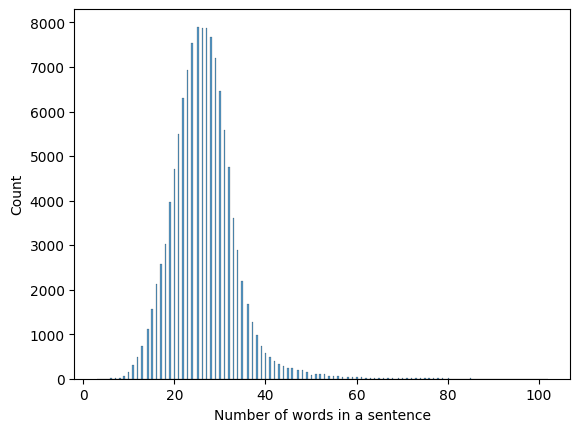

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data = train_df['cnt'])
plt.xlabel('Number of words in a sentence')
plt.ylabel('Count')
plt.show()

In [18]:
# Initializing tokenizer
tok = Tokenizer()
tok.fit_on_texts(train_df['tags'])
vocab_size = len(tok.word_index) + 1
max_len = 100

# Removing purely numeric tokens
def is_num(string):
    data = string.split()
    temp = []
    for i in data:
        if i.isnumeric() == False:
            temp.append(i)
    return ' '.join(temp)

train_df['tags'] = train_df['tags'].apply(is_num)

In [19]:
# Removing alphanumeric words

def is_alnum(string):
    return ' '.join(w for w in string.split() if not any(x.isdigit() for x in w))

train_df['tags'] = train_df['tags'].apply(is_alnum)

In [20]:
# Converting cleaned text to numerical sequence

encd_reviews = tok.texts_to_sequences(train_df['tags'])
embd_dim = 300
pad_reviews = pad_sequences(maxlen = max_len, padding='pre', sequences=encd_reviews)
pad_reviews.shape

(120000, 100)

In [21]:
pad_reviews[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,   421,   440,   778,  7970,    46,   761,    20,
           9,   694,  4071,   421,   308, 39423,  4660, 18851,   139,
         741], dtype=int32)

In [22]:
final_embeddings = np.zeros((vocab_size, embd_dim))
for word , i in tok.word_index.items():
    try:
        word_embedding = google_news_word2vec_model[word]
        if word_embedding is not None:
            final_embeddings[i] = word_embedding
    except:
            pass

In [23]:
len(final_embeddings)

73061

In [24]:
vocab_size

73061

In [25]:
final_embeddings[3]

array([ 1.12915039e-02,  2.89306641e-02,  8.34960938e-02, -4.98046875e-02,
       -1.30859375e-01, -1.09863281e-01, -1.15234375e-01, -7.47070312e-02,
       -8.93554688e-02,  2.18750000e-01,  3.71093750e-02,  9.47265625e-02,
        2.34375000e-02, -8.44726562e-02, -2.65625000e-01, -1.00585938e-01,
        4.63867188e-03,  1.15234375e-01,  8.25195312e-02,  2.06298828e-02,
       -3.68652344e-02, -3.20434570e-04, -9.91210938e-02,  1.58691406e-02,
       -6.34765625e-02,  1.87500000e-01,  8.98437500e-02,  1.77734375e-01,
        1.20117188e-01,  3.71093750e-02, -1.19628906e-01,  4.05273438e-02,
       -3.22265625e-02, -3.80859375e-02,  1.26953125e-01, -1.58203125e-01,
       -5.07812500e-02, -1.56250000e-01,  8.64257812e-02, -1.17187500e-01,
        1.39648438e-01, -1.59179688e-01, -4.07714844e-02,  1.22070312e-01,
        5.24902344e-02, -1.13281250e-01,  7.91015625e-02,  1.82617188e-01,
       -5.90820312e-02, -2.20947266e-02,  9.08203125e-02,  3.49121094e-02,
       -1.02539062e-02, -

In [26]:
import pickle

# Save the final_embeddings matrix
with open('final_embeddings_news_classifier.pkl', 'wb') as f:
    pickle.dump(final_embeddings, f)

In [27]:
# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = train_df['Class Index'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(pad_reviews, y, test_size=0.2)

In [28]:
X_train

array([[    0,     0,     0, ...,   181,  1720, 37489],
       [    0,     0,     0, ...,   500,    82,     5],
       [    0,     0,     0, ...,  1919, 18359, 21525],
       ...,
       [    0,     0,     0, ...,   372,  1753,    33],
       [    0,     0,     0, ...,   146,   195,   235],
       [    0,     0,     0, ...,   583,   280,  1387]], dtype=int32)

In [29]:
y_train

array([3, 3, 0, ..., 0, 3, 0])

In [30]:
from keras.initializers import Constant
from keras.layers import ReLU, Bidirectional
from keras.layers import Dropout
from keras.layers import GlobalMaxPool1D, AveragePooling1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Callback for early stopping during training
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=2,
    verbose=1,
    mode="auto",
    restore_best_weights=True
)

# Define the model architecture
model = Sequential()

# Input Layer
model.add(Input(shape=(max_len, )))

# Embedding Layer
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embd_dim,
    input_length=max_len,
    weights=[final_embeddings],  # Pre-trained embeddings
    trainable=False  # Don't train the embeddings during this phase
))

# Bidirectional LSTM Layer 1
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Bidirectional LSTM Layer 2
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Global Average Pooling
model.add(GlobalAveragePooling1D())

# Batch Normalization
model.add(BatchNormalization())

# Fully Connected Layers with Dropout and BatchNormalization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output Layer (Multi-class Classification)
model.add(Dense(4, activation='softmax'))

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │    21,918,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,600,768 (86.22 MB)

 Trainable params: 681,252 (2.60 MB)

 Non-trainable params: 21,919,516 (83.62 MB)

In [31]:
# Compiling and training the model

model.compile(optimizer='adam', metrics=['accuracy'], loss = 'sparse_categorical_crossentropy')

history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data = (X_test, y_test), callbacks=callback)

Epoch 1/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 899s 1s/step - accuracy: 0.7524 - loss: 0.7221 - val_accuracy: 0.8918 - val_loss: 0.3262
Epoch 2/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 945s 1s/step - accuracy: 0.8853 - loss: 0.3754 - val_accuracy: 0.8918 - val_loss: 0.3261
Epoch 3/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - accuracy: 0.8911 - loss: 0.3413 - val_accuracy: 0.8783 - val_loss: 0.3811
Epoch 4/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 937s 1s/step - accuracy: 0.9001 - loss: 0.3150 - val_accuracy: 0.9063 - val_loss: 0.2776
Epoch 5/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 894s 1s/step - accuracy: 0.9087 - loss: 0.2893 - val_accuracy: 0.8908 - val_loss: 0.3110
Epoch 6/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 921s 1s/step - accuracy: 0.9156 - loss: 0.2669 - val_accuracy: 0.9001 - val_loss: 0.2923
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


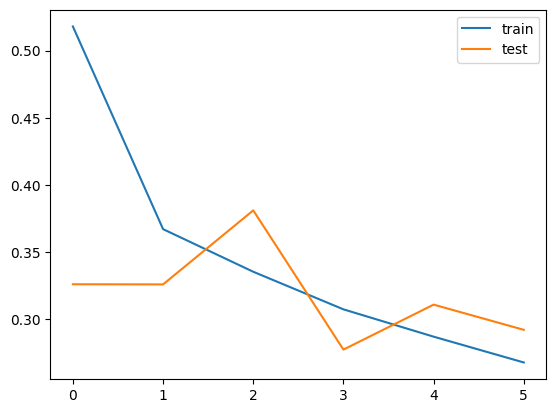

In [33]:
# Plot of vlaidation loss and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [32]:
# Training

LSTM_Word2Vec_train_score = model.evaluate(X_train, y_train, batch_size=1024, verbose=1)

print('Train Loss:', LSTM_Word2Vec_train_score[0])
print('Train Accuracy:', LSTM_Word2Vec_train_score[1])

94/94 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.9112 - loss: 0.2607
Train Loss: 0.2632826268672943
Train Accuracy: 0.9102916717529297


In [34]:
# Saving the model
model.save('News_Classification_bidirectional_lstm_model.keras')

In [35]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix

y_pred = model.predict([X_test], 1024)
y_pred = y_pred.argmax(axis=1)

y_pred
y_test

24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step


array([2, 3, 2, ..., 1, 2, 2])

In [36]:
# Classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5921
           1       0.95      0.98      0.97      6070
           2       0.84      0.91      0.87      6001
           3       0.91      0.85      0.88      6008

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000



In [42]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.9062916666666667
Precision 0.9078348446865478
Recall 0.9060214786057883
